In [70]:
import RF_utils as rfut
from RF_feature_importance import evaluate_model_with_shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, RandomizedSearchCV
from scipy.stats import randint, uniform

# Load your data
csv_fn = r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Watershed Stats\Hillslopes\Stream Clipped Hillslopes Pruned\Hillslope_Stats_Combined 050224.csv"
variables_to_exclude = ['ID', 'Erosion mean', "Category", "OBJECTID", "Deposition mean", "Deposition stdev", "Erosion stdev", "Watershed",
                        "Deposition mean Masked", "Deposition stdev Masked", "Erosion mean Masked", "Erosion stdev Masked", 'Erosion Volsum Masked',    
                        'Erosion Volsum Masked Count', 'Erosion Volsum over count', 'Deposition Volsum Masked', 'Deposition Volsum Masked Count',  
                        'perimeter', "width", "length", "area", "Curvature", "width_over_length",  
                        # "Aspect Mean", "Aspect std",   "dummy", "Slope Mean", "Mulch Coverage %",
                        ]

y_field = 'Erosion Volsum over count'

def load_data(file_path, exclude_vars, y_var):
    data = pd.read_csv(file_path)
    data = data[data['Erosion Volsum Masked Count'] >= 1]
    X = data.drop(columns=exclude_vars + [y_var])
    y = data[y_var].dropna()
    X = X.loc[y.index]
    X = pd.get_dummies(X)  # Convert categorical columns to dummy variables
    #drop rows where y is greater than -0.20
    y = y[y <= -0.20]
    X = X.loc[y.index]

    return X, y

def remove_outliers(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    condition = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[condition], y[condition]

def hyperparameter_optimization(X, y):
    param_dist = {
        'n_estimators': randint(300, 500),  # Increased upper range
        'max_depth': randint(3, 15),         # Increased depth for more complex models
        'learning_rate': uniform(0.05, 0.2), # Wider range for learning rate
        'subsample': uniform(0.4, 6),
        'colsample_bytree': uniform(0.4, 0.6),
        'min_child_weight': randint(10, 15),
        'reg_lambda': uniform(0.5, 1.5),
        'reg_alpha': uniform(0.4, 0.6)
    }

    model = XGBRegressor()
    rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=200, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    rsearch.fit(X, y)
    return rsearch.best_estimator_



# Load data
X, y = load_data(csv_fn, variables_to_exclude, y_field)
#X, y = remove_outliers(X, y)  # Removing outliers

best_model = hyperparameter_optimization(X, y)
#best_model = XGBRegressor(n_estimators=350, max_depth=18)

Mean Squared Error: 0.052860104933889256
Mean Squared Error: 0.11614157224974477


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Mean Squared Error: 0.019858683318757023
Mean Squared Error: 0.034413888626698544


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Mean Squared Error: 0.0640768165408241
Score: 0.048368407720243464
Average R^2: 0.1522256519254804
Average MSE: 0.05747021313398273
Feature Importance


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


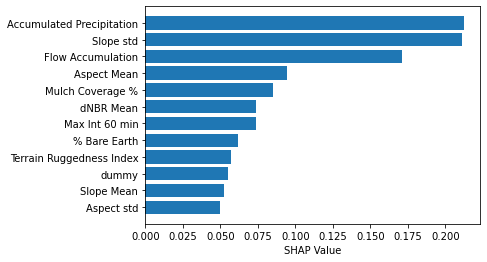

In [71]:
# get score of best_model
# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
shap_DICT ={}
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    
    mse, predictions = rfut.evaluate_model(best_model, X_test, y_test)
    predictions_series = pd.Series(predictions, index=y_test.index)
    R2 = y_test.corr(predictions_series)**2
    results.append({'MSE': mse, 'R2': R2, 'score': best_model.score(X_test, y_test)})
    RANKED_shap, _ = evaluate_model_with_shap(best_model, X_train, X_test, plot =False)
    for key in RANKED_shap['Feature']:
        if key in shap_DICT:
            shap_DICT[key] += RANKED_shap['SHAP Importance'][RANKED_shap['Feature'] == key].values[0]
        else:
            shap_DICT[key] = RANKED_shap['SHAP Importance'][RANKED_shap['Feature'] == key].values[0]
# Print summary of results
score = np.mean([r['score'] for r in results])  
mean_R2 = np.mean([r['R2'] for r in results])
mean_MSE = np.mean([r['MSE'] for r in results])
print(f"Score: {score}")
print(f"Average R^2: {mean_R2}")
print(f"Average MSE: {mean_MSE}")
print("Feature Importance")
#plot shap values as a bar chart with feature names on the y axis with the most important feature at the top
#convert shap_DICT to a dataframe
shap_df = pd.DataFrame(shap_DICT.items(), columns = ['Feature', 'SHAP Importance'])
shap_df = shap_df.sort_values(by = 'SHAP Importance', ascending = True)
shap_df = shap_df.reset_index(drop = True)
#plot the top 10 features
plt.barh(shap_df['Feature'], shap_df['SHAP Importance'])
plt.xlabel('SHAP Value')
plt.show()

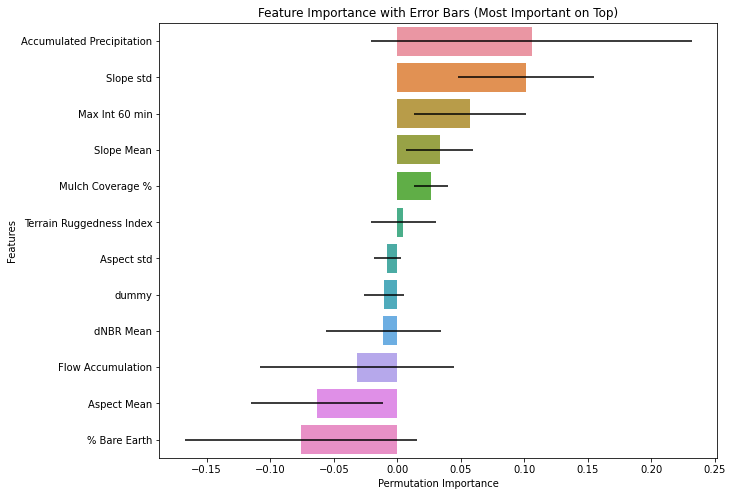

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.inspection import permutation_importance

# Assuming best_model, X_test, y_test are already defined
# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42)

# Prepare the data for plotting
importances = perm_importance.importances_mean[perm_importance.importances_mean.argsort()]
std = perm_importance.importances_std[perm_importance.importances_mean.argsort()]
features = X_test.columns[perm_importance.importances_mean.argsort()]

# Reverse the order so the most important feature is at the top
importance_data = pd.DataFrame({
    'Features': features[::-1],
    'Importances': importances[::-1],
    'Std': std[::-1]
})

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importances', y='Features', data=importance_data, xerr=importance_data['Std'])

plt.xlabel('Permutation Importance')
plt.title('Feature Importance with Error Bars (Most Important on Top)')
plt.show()


Correlation: 0.12407250980891629
Number of training samples: 210
Number of testing samples: 52


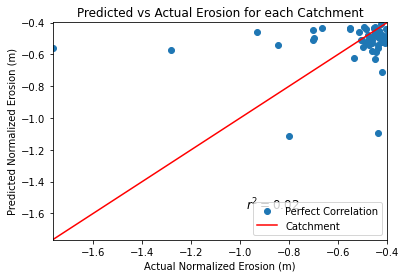

Average Erosion: -0.5374227594615384
Standard Deviation of Erosion: 0.2339175897686824
MSE of the model: 0.05747021313398273


In [73]:
#make a data frame from y_test and predictions
df = pd.DataFrame(y_test)
#name the column y_field
df[y_field] = y_test
df['predictions'] = predictions
#plot the predictions vs y_test so x and y are the same

#get the correlation between the predictions and y_test
correlation = df[y_field].corr(df['predictions'])
print(f"Correlation: {correlation}")

print(f"Number of training samples: {len(y_train)}")
print(f"Number of testing samples: {len(y_test)}")

plt.scatter(df[y_field], df['predictions'])
plt.xlabel('Actual Normalized Erosion (m)')
plt.ylabel('Predicted Normalized Erosion (m)')
#set axis to be the same bounds
plt.xlim(min(df[y_field]), max(df[y_field]))
plt.ylim(min(df[y_field]), max(df[y_field]))
#plot a perfect correlation line
plt.plot([min(df[y_field]), max(df[y_field])], [min(df[y_field]), max(df[y_field])], color='red')
plt.title('Predicted vs Actual Erosion for each Catchment')
#add the r^2 to the plot legend, formatted to 2 decimal places
#also add the perfect correlation line
r2 = round(correlation**2, 2)
#make r^2 with the exponent
# Ensure you have defined the appropriate y_field in your DataFrame
y_min = min(y_test)
y_max = max(y_test)
x_min = min(df['predictions'])
x_max = max(df['predictions'])
x_position = x_min + 0.2 * (x_max - x_min)
y_position = y_max - 0.8 * (y_max - y_min)
plt.text(x_position, y_position, r"$r^2=    {:.2f}$".format(r2), fontsize=12, fontweight='bold',
         verticalalignment='top', horizontalalignment='left', backgroundcolor='white', color='black')

plt.legend(['Perfect Correlation', 'Catchment'], loc='lower right')

plt.show()
print(f"Average Erosion: {np.mean(y_test)}")
print(f"Standard Deviation of Erosion: {np.std(y_test)}")
print(f"MSE of the model: {mean_MSE}")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


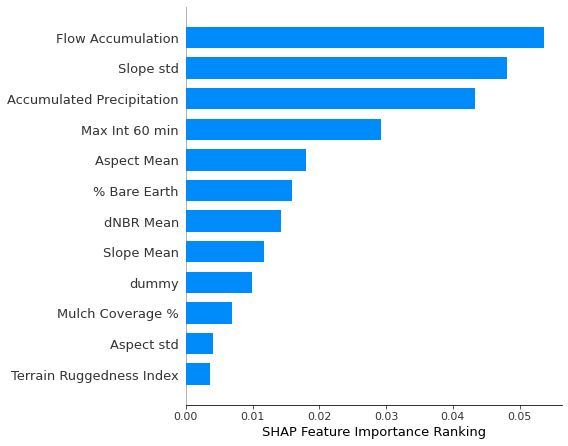

                      Feature  SHAP Importance
0           Flow Accumulation         0.053598
1                   Slope std         0.048075
2   Accumulated Precipitation         0.043265
3              Max Int 60 min         0.029194
4                 Aspect Mean         0.017965
5                % Bare Earth         0.015972
6                   dNBR Mean         0.014214
7                  Slope Mean         0.011707
8                       dummy         0.009838
9            Mulch Coverage %         0.006890
10                 Aspect std         0.004048
11   Terrain Ruggedness Index         0.003676


In [74]:
from RF_feature_importance import evaluate_model_with_shap
feature_list, shap_plot = evaluate_model_with_shap(best_model, X_train, X_test)
print(feature_list)
display(shap_plot)

(array([  1.,   0.,   0.,   0.,   2.,   2.,   6.,  15.,  35., 201.]),
 array([-2.68969727, -2.4592041 , -2.22871094, -1.99821777, -1.76772461,
        -1.53723145, -1.30673828, -1.07624512, -0.84575195, -0.61525879,
        -0.38476562]),
 <BarContainer object of 10 artists>)

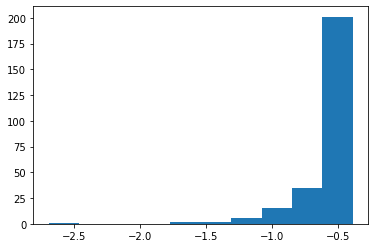

In [75]:
# plot histogram of y
plt.hist(y)

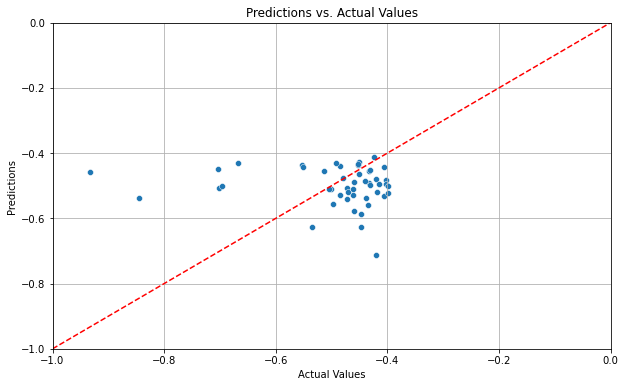

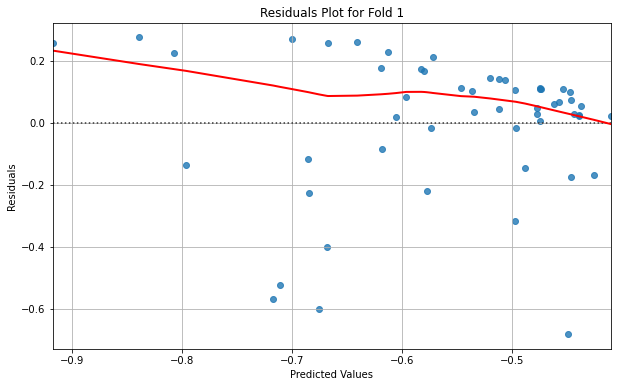

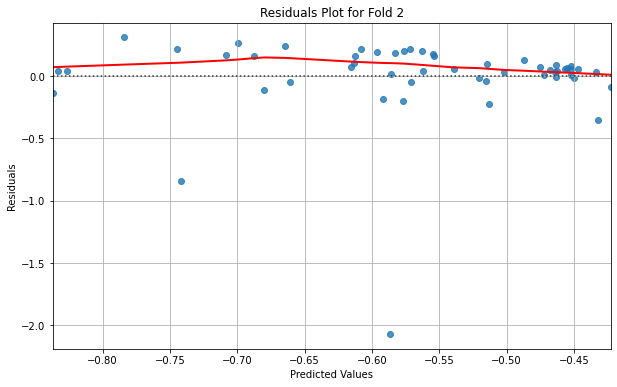

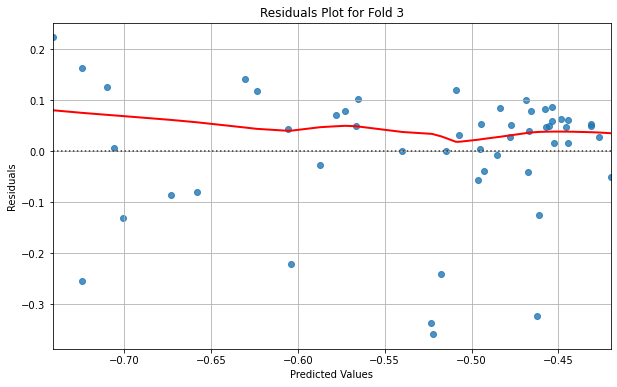

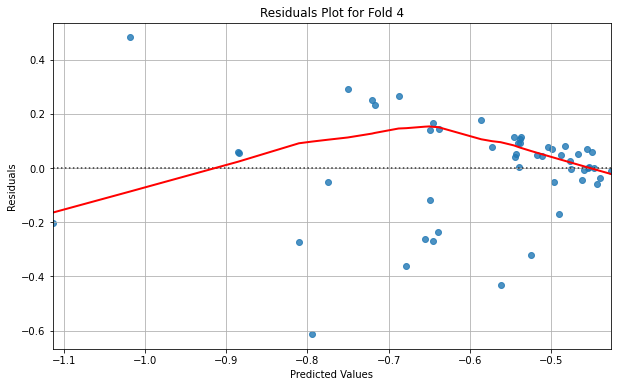

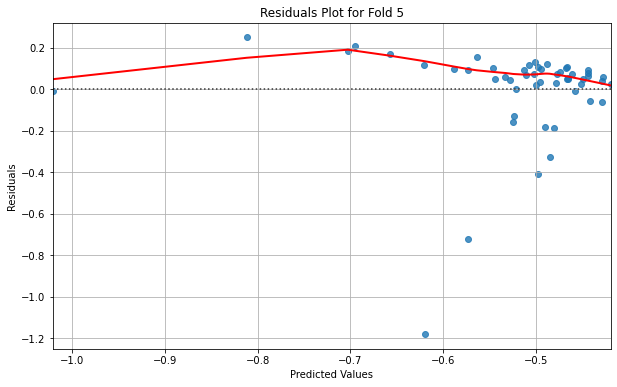

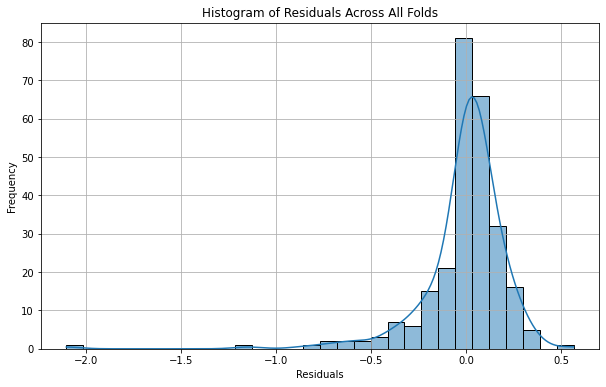

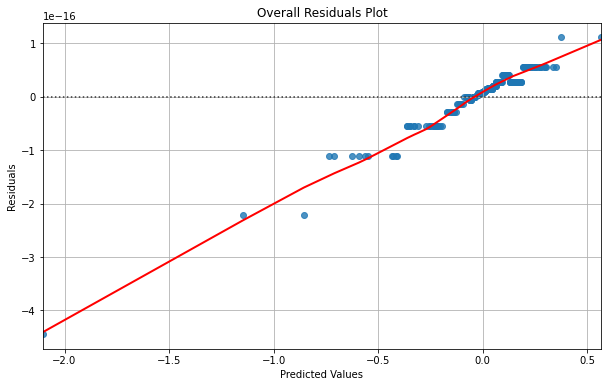

Mean of Residuals: -0.011424545281840197
Standard Deviation of Residuals: 0.23626610968566486


In [76]:
# Import additional necessary libraries
import seaborn as sns

#plot predictions vs. actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions_series)
plt.title('Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
#make both axis limits the same
plt.xlim(-1, 0)
plt.ylim(-1, 0)
#make it a 1:1 line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red")
plt.grid(True)
plt.show()

# Results collection from the cross-validation loop
residuals = []

# Continue from the cross-validation loop in the previous code
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    predictions_series = pd.Series(predictions, index=y_test.index)
    
    # Calculate residuals
    residuals_fold = y_test - predictions_series
    residuals.append(residuals_fold)
    
    # Plotting residuals for each fold
    plt.figure(figsize=(10, 6))
    sns.residplot(x=predictions_series, y=residuals_fold, lowess=True, line_kws={'color': 'red', 'lw': 2})
    plt.title(f'Residuals Plot for Fold {len(residuals)}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

# Combine all residuals into a single DataFrame for overall analysis
all_residuals = pd.concat(residuals)

# Plotting overall residuals
plt.figure(figsize=(10, 6))
sns.histplot(all_residuals, kde=True, bins=30)
plt.title('Histogram of Residuals Across All Folds')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting residuals vs. predicted values for all data
plt.figure(figsize=(10, 6))
sns.residplot(x=pd.concat([y_test for y_test in residuals]), y=all_residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.title('Overall Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Assess overall bias and variance
print(f"Mean of Residuals: {all_residuals.mean()}")
print(f"Standard Deviation of Residuals: {all_residuals.std()}")
